# Day and Night Image Classifier
---

The day/night image dataset consists of 200 RGB color images in two categories: day and night. There are equal numbers of each example: 100 day images and 100 night images.

We'd like to build a classifier that can accurately label these images as day or night, and that relies on finding distinguishing features between the two types of images!

*Note: All images come from the [AMOS dataset](http://cs.uky.edu/~jacobs/datasets/amos/) (Archive of Many Outdoor Scenes).*


### Import resources

In [1]:
import os
import glob # library for loading images from a directory

import cv2 # computer vision library
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Training and Testing Data
The 200 day/night images are separated into training and testing datasets. 

* 60% of these images are training images, for you to use as you create a classifier.
* 40% are test images, which will be used to test the accuracy of your classifier.

In [2]:
# Image data directories
image_dir_training = "day_night_images/training/"
image_dir_test = "day_night_images/test/"

## Load the datasets

### Function to load dataset

In [3]:
# This function loads in images and their labels and places them in a list
# The list contains all images and their associated labels
# For example, after data is loaded, im_list[0][:] will be the first image-label pair in the list
def load_dataset(image_dir):
    
    # Populate this empty image list
    im_list = []
    image_types = ["day", "night"]
    
    # Iterate through each color folder
    for im_type in image_types:
        
        # Iterate through each image file in each image_type folder
        # glob reads in any image with the extension "image_dir/im_type/*"
        for file in glob.glob(os.path.join(image_dir, im_type, "*")):
            
            # Read in the image
            im = mpimg.imread(file)
            
            # Check if the image exists/if it's been correctly read-in
            if not im is None:
                # Append the image, and it's type (day,night) to the image list
                im_list.append((im, im_type))
    
    return im_list

In [4]:
# Load training data
train_image_list = load_dataset(image_dir_training)

## Construct a `standardized_list` of input images and output labels.

In [5]:
#This function takes in a list of image-label pairs and outputs a **standardized** list of resized images and numerical labels.
def standardize_input(image):
    # Resize image and pre-process so that all "standard" images are the same size
    standard_im = cv2.resize(image, (1100, 600))
    return standard_im

In [6]:
#label encoding
def encode(label):
    numerical_val = 0
    if(label == 'day'):
        numerical_val = 1
    return numerical_val

In [7]:
# using both functions above, standardize the input images and output labels
def standardize(image_list):
    
    # Empty image data array
    standard_list = []
    
    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]
        
        # Standardize the image
        standardized_im = standardize_input(image)
        
        # Create a numerical label
        binary_label = encode(label)
        
        # Append the image, and it's one hot encoded label to the full, processed list of image data
        standard_list.append((standardized_im, binary_label))
    
    return standard_list


In [8]:
# Standardize all training images
standardized_list = standardize(train_image_list)

## Visualize the standardized data

Display a standardized image from train_image_list.

Shape:  (600, 1100, 3)
Label [1 = day, 0 = night]:  1


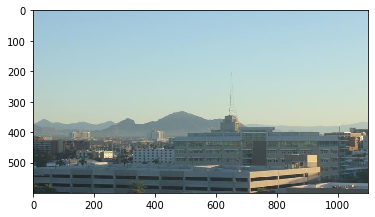

In [9]:
# Select an image by index
image_num = 0
selected_image = standardized_list[image_num][0]
selected_label = standardized_list[image_num][1]

# Display image and data about it
plt.imshow(selected_image)

#print shape and label
print("Shape: ",selected_image.shape)
print("Label [1 = day, 0 = night]: " , selected_label)

# Feature Extraction

*  We'll be extracting the **average brightness** using HSV colorspace. Specifically, we'll use the V channel (a measure of brightness), add up the pixel values in the V channel, then divide that sum by the area of the image to get the average Value of the image.


### Function which return average brightness 

In [10]:
area = 600*1100  # pixels
# Find the average Value or brightness of an image
def avg_brightness(rgb_image):
    # Convert image to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    # Add up all the pixel values in the V channel
    sum_brightness = np.sum(hsv[:,:,2])

    # find the avg
    avg = sum_brightness/area
    
    return avg

### Testing average brightness levels

Avg brightness: 35.217


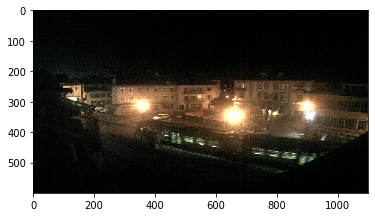

In [11]:
# As an example, a "night" image is loaded in and its avg brightness is displayed
image_num = 190
test_im = standardized_list[image_num][0]

avg = avg_brightness(test_im)
print('Avg brightness: ' + str(avg))
plt.imshow(test_im)

Avg brightness: 175.1298712121212


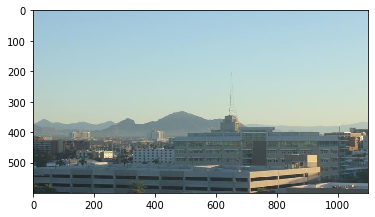

In [12]:
# "day" image is loaded in and its avg brightness is displayed
image_num = 0
test_im = standardized_list[image_num][0]
avg = avg_brightness(test_im)
print('Avg brightness: ' + str(avg))
plt.imshow(test_im)

# Classification and Visualizing Error

In [13]:
#setting the threshold
threshold = 100

# list of misclassified average brightness 
mis_avg = []

# This function should take in RGB image input
def estimate_label(rgb_image):
    
    # Extract average brightness feature from an RGB image 
    avg = avg_brightness(rgb_image)
        
    # Use the avg brightness feature to predict a label (0, 1)
    predicted_label = 0
    
    if(avg > threshold):
        # if the average brightness is above the threshold value, we classify it as "day"
        predicted_label = 1
        # else, the pred-cted_label can stay 0 (it is predicted to be "night")
    else:
        mis_avg.append(avg)
    
    return predicted_label

## Testing the classifier
### Test dataset

Below, we load in the test dataset, standardize it using the `standardize` function defined above, and then **shuffle** it; this ensures that order will not play a role in testing accuracy.


In [14]:
import random
# Load test data
test_image_list = load_dataset(image_dir_test)

# Standardize the test data
standardized_test_list = standardize(test_image_list)

# Shuffle the standardized test data
random.shuffle(standardized_test_list)

## Determine the Accuracy

* Compare the output of our classification algorithm (a.k.a. our "model") with the true labels and determine the accuracy.

* This code stores all the misclassified images, their predicted labels, and their true labels, in a list called `misclassified`.

In [15]:
# Constructs a list of misclassified images given a list of test images and their labels
def get_misclassified_images(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]

        # Get predicted label from your classifier
        predicted_label = estimate_label(im)

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels


In [16]:
# Find all misclassified images in a given test set
misclassified = get_misclassified_images(standardized_test_list)

# Accuracy calculations
total = len(standardized_test_list)
num_correct = total - len(misclassified)
accuracy = num_correct/total

print('Accuracy: ',accuracy)
print("Number of misclassified images = {} out of {}".format(len(misclassified),total))

Accuracy:  0.925
Number of misclassified images = 12 out of 160


### Visualize the misclassified images

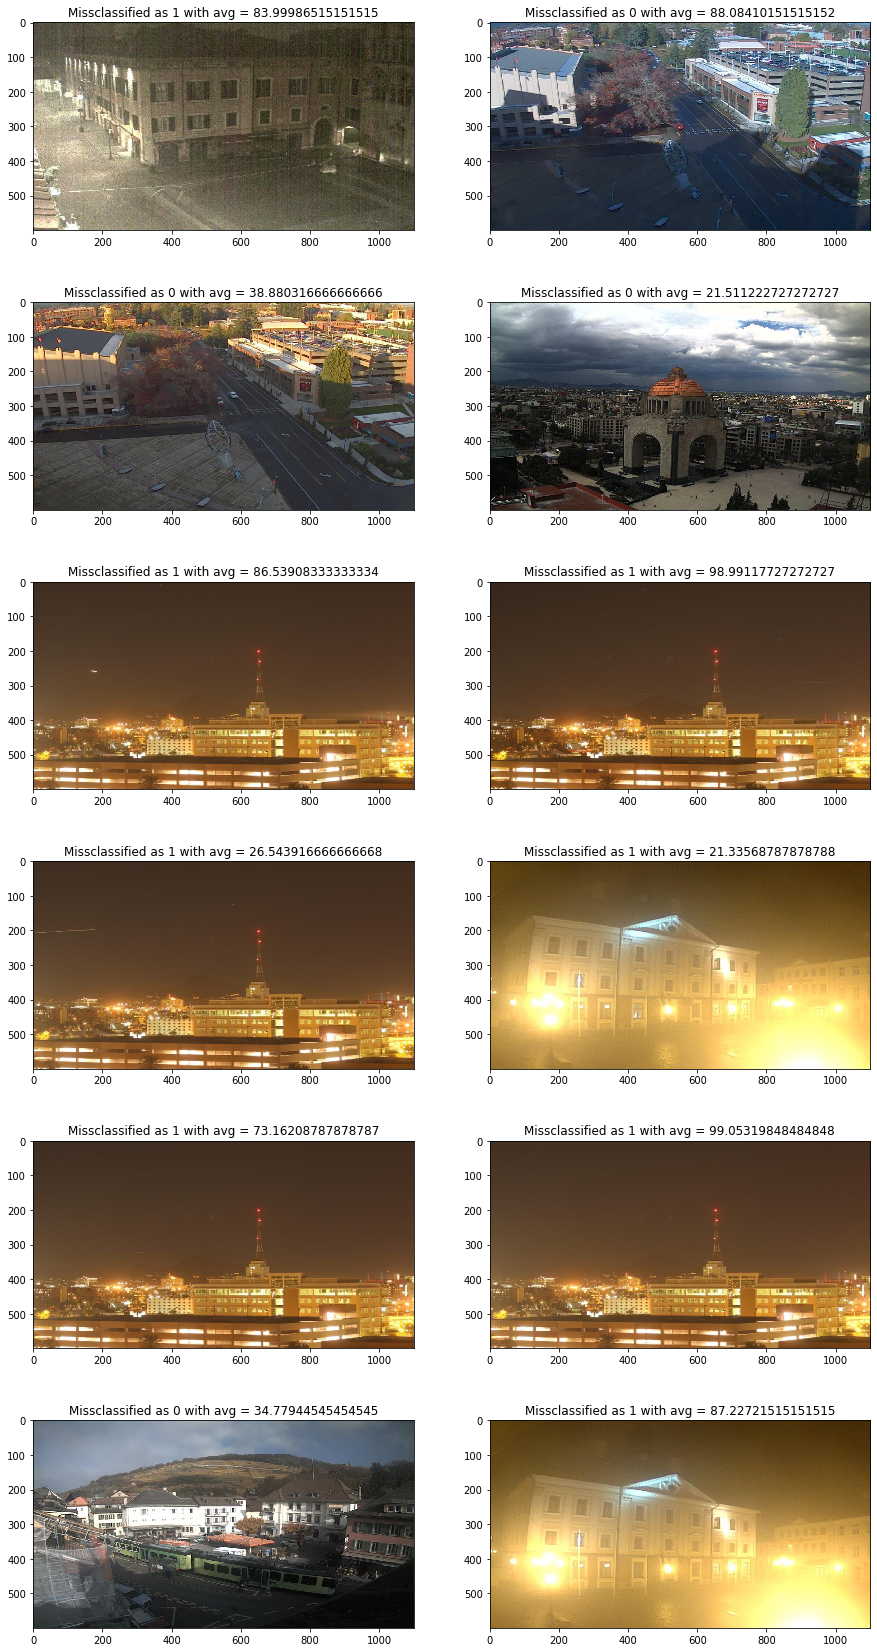

In [17]:
plt.figure(figsize = (15,30))
for i in range(0,12):
    plt.subplot(6,2,i+1)
    test_mis_im = misclassified[i][0]
    plt.imshow(test_mis_im)
    plt.title('Missclassified as {} with avg = {}'.format(misclassified[i][1],mis_avg[i]))
